This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
len(df)

10000

In [4]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

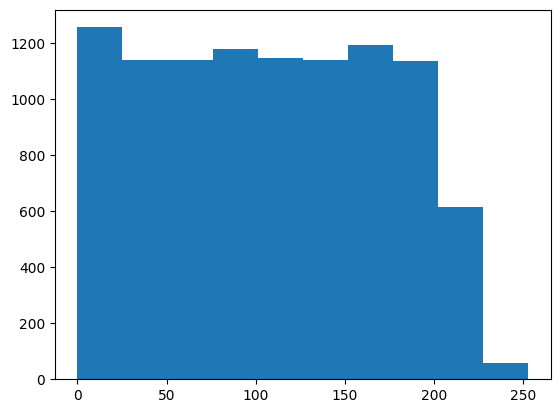

In [5]:
fig, ax = plt.subplots()
ax.hist(df['Tool wear [min]']);

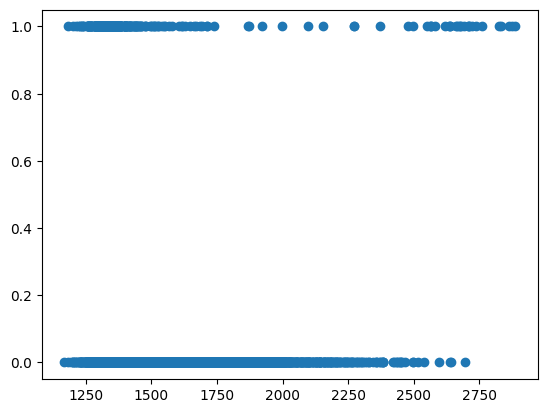

In [6]:
fig, ax = plt.subplots()
ax.scatter(df['Rotational speed [rpm]'], df['Machine failure'])

In [7]:
# Creating a copy of the original dataframe.

org_df = df.copy()

# **Data preprocessing and cleaning**

In [8]:
# Calculate mean and standard deviation
mean_air_temp = df['Air temperature [K]'].mean()
std_dev_air_temp = df['Air temperature [K]'].std()

mean_process_temp = df['Process temperature [K]'].mean()
std_dev_process_temp = df['Process temperature [K]'].std()

# Normalize 'air temperature' column
df['Normalized_air_temp'] = ((df['Air temperature [K]'] - mean_air_temp) / std_dev_air_temp) * 2 + 300

# Normalize 'process temperature' column
df['Normalized_process_temp'] = ((df['Process temperature [K]'] - mean_process_temp) / std_dev_process_temp) + 300

# Drop original columns if needed
df.drop(['Air temperature [K]', 'Process temperature [K]'], axis=1, inplace=True)

In [9]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp
0,1,M14860,M,1551,42.8,0,0,0,0,0,0,0,298.095316,299.052687
1,2,L47181,L,1408,46.3,3,0,0,0,0,0,0,298.195303,299.120085
2,3,L47182,L,1498,49.4,5,0,0,0,0,0,0,298.095316,298.985290
3,4,L47183,L,1433,39.5,7,0,0,0,0,0,0,298.195303,299.052687
4,5,L47184,L,1408,40.0,9,0,0,0,0,0,0,298.195303,299.120085


In [10]:
df.describe()

,UDI,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,5000.50000,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190,300.000000,300.000000
std,2886.89568,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355,2.000000,1.000000
min,1.00000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,295.295678,297.098160
25%,2500.75000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,298.295290,299.187483
50%,5000.50000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,300.095058,300.063650
75%,7500.25000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,301.494877,300.737625
max,10000.00000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,304.494489,302.557358


In [11]:
# Ensuring there is no negative values im torque column

# Step 1: Identify negative values in the 'torque' column
negative_values = df[df['Torque [Nm]'] < 0]

# Step 2: Replace negative values with their absolute values
df.loc[df['Torque [Nm]'] < 0, 'Torque [Nm]'] = df.loc[df['Torque [Nm]'] < 0, 'Torque [Nm]'].abs()

# Check if there are still negative values (should return an empty DataFrame)
negative_values_after_correction = df[df['Torque [Nm]'] < 0]

# If the DataFrame is empty, it means there are no negative values in the 'torque' column
if negative_values_after_correction.empty:
    print("No negative values in the 'torque' column.")
else:
    print("Negative values in the 'torque' column have been corrected.")

No negative values in the 'torque' column.


In [12]:
# Calculate power using torque and rotational speed
df['Power [W]'] = df['Torque [Nm]'] * (2 * 3.14159 * df['Rotational speed [rpm]'] / 60)

In [13]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W]
0,1,M14860,M,1551,42.8,0,0,0,0,0,0,0,298.095316,299.052687,6951.584688
1,2,L47181,L,1408,46.3,3,0,0,0,0,0,0,298.195303,299.120085,6826.716958
2,3,L47182,L,1498,49.4,5,0,0,0,0,0,0,298.095316,298.985290,7749.380997
3,4,L47183,L,1433,39.5,7,0,0,0,0,0,0,298.195303,299.052687,5927.499652
4,5,L47184,L,1408,40.0,9,0,0,0,0,0,0,298.195303,299.120085,5897.811627


In [14]:
df['Type'].describe()

count     10000
unique        3
top           L
freq       6000
Name: Type, dtype: object

**Calculating `tool wear` based on the quality variants(H/M/L) and add corresponding minutes to the column.**

* The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

In [15]:
# Step 1 : Define additonal minutes of tool wear for each quality variant.
additional_tool_wear = {'H' : 5, 'M' : 3, 'L' : 2}

# Step 2 : Map quality variants to additional minutes of tool wear based on 'Product ID'.
df['Additional tool wear'] = df['Product ID'].str[0].map(additional_tool_wear)

# Step 3 : Add the calculated additional minutes of tool wear to the existing 'tool wear' column.
df['Tool wear [min]'] += df['Additional tool wear']

In [16]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W],Additional tool wear
0,1,M14860,M,1551,42.8,3,0,0,0,0,0,0,298.095316,299.052687,6951.584688,3
1,2,L47181,L,1408,46.3,5,0,0,0,0,0,0,298.195303,299.120085,6826.716958,2
2,3,L47182,L,1498,49.4,7,0,0,0,0,0,0,298.095316,298.985290,7749.380997,2
3,4,L47183,L,1433,39.5,9,0,0,0,0,0,0,298.195303,299.052687,5927.499652,2
4,5,L47184,L,1408,40.0,11,0,0,0,0,0,0,298.195303,299.120085,5897.811627,2


In [17]:
# Dropping additional tool wear column since it isnt required.
df.drop('Additional tool wear', axis= 1, inplace= True)

In [18]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W]
0,1,M14860,M,1551,42.8,3,0,0,0,0,0,0,298.095316,299.052687,6951.584688
1,2,L47181,L,1408,46.3,5,0,0,0,0,0,0,298.195303,299.120085,6826.716958
2,3,L47182,L,1498,49.4,7,0,0,0,0,0,0,298.095316,298.985290,7749.380997
3,4,L47183,L,1433,39.5,9,0,0,0,0,0,0,298.195303,299.052687,5927.499652
4,5,L47184,L,1408,40.0,11,0,0,0,0,0,0,298.195303,299.120085,5897.811627


In [19]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
Normalized_air_temp        0
Normalized_process_temp    0
Power [W]                  0
dtype: int64

In [20]:
# Define a function to determine the type of failure for each data point
def determine_failure_type(row):
    if row['Tool wear [min]'] >= 200 and row['Tool wear [min]'] <= 240:
        if row['Type'] == 'H':
            return 'Tool Wear Failure'
    if abs(row['Normalized_air_temp'] - row['Normalized_process_temp']) < 8.6 and row['Rotational speed [rpm]'] < 1380:
        return 'Heat Dissipation Failure'
    if row['Power [W]'] < 3500 or row['Power [W]'] > 9000:
        return 'Power Failure'
    if (row['Type'] == 'L' and row['Torque [Nm]'] * row['Tool wear [min]'] > 11000) or (row['Type'] == 'M' and row['Torque [Nm]'] * row['Tool wear [min]'] > 12000) or (row['Type'] == 'H' and row['Torque [Nm]'] * row['Tool wear [min]'] > 13000):
        return 'Overstrain Failure'
    if row['RNF'] == 1:
        return 'Random Failure'
    return 'No Failure'

# Apply the function to each row to determine the type of failure
df['Machine failure Labelled'] = df.apply(determine_failure_type, axis=1)

In [21]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M14860,M,1551,42.8,3,0,0,0,0,0,0,298.095316,299.052687,6951.584688,No Failure
1,2,L47181,L,1408,46.3,5,0,0,0,0,0,0,298.195303,299.120085,6826.716958,No Failure
2,3,L47182,L,1498,49.4,7,0,0,0,0,0,0,298.095316,298.985290,7749.380997,No Failure
3,4,L47183,L,1433,39.5,9,0,0,0,0,0,0,298.195303,299.052687,5927.499652,No Failure
4,5,L47184,L,1408,40.0,11,0,0,0,0,0,0,298.195303,299.120085,5897.811627,No Failure


**Calculating Z-score for the data to find outliers.**

In [22]:
# Select columns with numerical data types
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# Define a function to calculate Z-score for a column
def calculate_z_score(column):
    mean = column.mean()
    std_dev = column.std()
    z_scores = (column - mean) / std_dev
    return z_scores

# Calculate Z-score for each numerical column
z_scores_df = df[numerical_columns].apply(calculate_z_score)

# Display the DataFrame with Z-scores for each numerical column
z_scores_df.head()

,UDI,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W]
0,-1.731791,0.068182,0.282186,-1.689600,-0.187313,-0.067976,-0.107855,-0.097929,-0.099479,-0.043628,-0.952342,-0.947313,0.629412
1,-1.731445,-0.729435,0.633276,-1.658181,-0.187313,-0.067976,-0.107855,-0.097929,-0.099479,-0.043628,-0.902348,-0.879915,0.512431
2,-1.731098,-0.227438,0.944242,-1.626762,-0.187313,-0.067976,-0.107855,-0.097929,-0.099479,-0.043628,-0.952342,-1.014710,1.376820
3,-1.730752,-0.589992,-0.048843,-1.595342,-0.187313,-0.067976,-0.107855,-0.097929,-0.099479,-0.043628,-0.902348,-0.947313,-0.329993
4,-1.730405,-0.729435,0.001313,-1.563923,-0.187313,-0.067976,-0.107855,-0.097929,-0.099479,-0.043628,-0.902348,-0.879915,-0.357806


In [23]:
z_scores_df.drop(['UDI', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [24]:
z_scores_df.head()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W]
0,0.068182,0.282186,-1.689600,-0.952342,-0.947313,0.629412
1,-0.729435,0.633276,-1.658181,-0.902348,-0.879915,0.512431
2,-0.227438,0.944242,-1.626762,-0.952342,-1.014710,1.376820
3,-0.589992,-0.048843,-1.595342,-0.902348,-0.947313,-0.329993
4,-0.729435,0.001313,-1.563923,-0.902348,-0.879915,-0.357806


In [25]:
z_scores_df.describe()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W]
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-2.344791e-16,5.435652e-16,9.805490e-17,-1.409717e-15,-2.353318e-15,-1.339373e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.068093e+00,-3.629968e+00,-1.705310e+00,-2.352161e+00,-2.901840e+00,-4.807210e+00
25%,-6.457689e-01,-6.808060e-01,-8.609152e-01,-8.523548e-01,-8.125175e-01,-6.731761e-01
50%,-1.995498e-01,1.134424e-02,-8.665455e-03,4.752885e-02,6.365021e-02,-8.167004e-03
75%,4.084238e-01,6.834322e-01,8.553665e-01,7.474383e-01,7.376254e-01,6.775767e-01
max,7.514464e+00,3.672719e+00,2.284947e+00,2.247244e+00,2.557358e+00,3.925526e+00


In [26]:
# Define a threshold for outlier detection (e.g., Z-score greater than 3)
threshold = 3

# Create a DataFrame to store outliers
outliers_df = pd.DataFrame()

# Iterate over each column and identify outliers based on the threshold
for column in z_scores_df.columns:
    outliers_df[column] = z_scores_df[column][abs(z_scores_df[column]) > threshold]

# Display the DataFrame with outliers
outliers_df.head()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W]
50,7.375021,-3.549719,NaN,NaN,NaN,-4.591986
194,6.354294,NaN,NaN,NaN,NaN,-3.071937
298,3.292115,NaN,NaN,NaN,NaN,NaN
305,3.292115,NaN,NaN,NaN,NaN,NaN
344,5.071414,NaN,NaN,NaN,NaN,NaN


In [27]:
len(outliers_df)

164

In [28]:
outliers_df.index

Index([  50,  194,  298,  305,  344,  380,  400,  418,  463,  467,
       ...
       9406, 9444, 9601, 9724, 9732, 9758, 9832, 9849, 9865, 9939],
      dtype='int64', length=164)

In [29]:
# Define a function to remove outliers based on the DataFrame containing outliers
def remove_outliers_from_df(df, outliers_df):
    # Create a copy of the original DataFrame to avoid modifying the original data
    df_copy = df.copy()
    
    # Get the indices of outliers from the outlier DataFrame
    outlier_indices = outliers_df.index
    
    # Drop rows with outlier indices from the copy of the original DataFrame
    df_copy = df_copy.drop(outlier_indices)
    
    return df_copy

# Call the function to remove outliers from the original DataFrame
df_without_outliers = remove_outliers_from_df(df, outliers_df)

In [30]:
df_without_outliers.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M14860,M,1551,42.8,3,0,0,0,0,0,0,298.095316,299.052687,6951.584688,No Failure
1,2,L47181,L,1408,46.3,5,0,0,0,0,0,0,298.195303,299.120085,6826.716958,No Failure
2,3,L47182,L,1498,49.4,7,0,0,0,0,0,0,298.095316,298.985290,7749.380997,No Failure
3,4,L47183,L,1433,39.5,9,0,0,0,0,0,0,298.195303,299.052687,5927.499652,No Failure
4,5,L47184,L,1408,40.0,11,0,0,0,0,0,0,298.195303,299.120085,5897.811627,No Failure


In [31]:
len(df_without_outliers)

9836

## **Saving preprocessed data**

In [32]:
df_without_outliers.to_csv('data/preprocessed_data.csv')

In [33]:
wrk_df = pd.read_csv('data/preprocessed_data.csv', index_col=0)

In [34]:
wrk_df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M14860,M,1551,42.8,3,0,0,0,0,0,0,298.095316,299.052687,6951.584688,No Failure
1,2,L47181,L,1408,46.3,5,0,0,0,0,0,0,298.195303,299.120085,6826.716958,No Failure
2,3,L47182,L,1498,49.4,7,0,0,0,0,0,0,298.095316,298.985290,7749.380997,No Failure
3,4,L47183,L,1433,39.5,9,0,0,0,0,0,0,298.195303,299.052687,5927.499652,No Failure
4,5,L47184,L,1408,40.0,11,0,0,0,0,0,0,298.195303,299.120085,5897.811627,No Failure


In [35]:
wrk_df[['HDF', 'TWF', 'PWF', 'OSF', 'RNF']].value_counts()

HDF  TWF  PWF  OSF  RNF
0    0    0    0    0      9521
1    0    0    0    0       106
0    0    0    1    0        78
          1    0    0        49
     1    0    0    0        40
     0    0    0    1        18
          1    1    0        11
1    0    0    1    0         6
          1    0    0         3
0    1    0    1    0         2
               0    1         1
          1    1    0         1
Name: count, dtype: int64

In [36]:
wrk_df['Machine failure Labelled'].value_counts()

Machine failure Labelled
No Failure                  8332
Heat Dissipation Failure    1354
Tool Wear Failure             91
Overstrain Failure            24
Power Failure                 19
Random Failure                16
Name: count, dtype: int64

In [37]:
# Define a function to calculate machine failure based on the specified conditions
def calculate_machine_failure(row):
    failure_modes = []
    
    # Tool Wear Failure (TWF)
    if 200 <= row['Tool wear [min]'] <= 240:
        failure_modes.append('TWF')

    # Heat Dissipation Failure (HDF)
    if (row['Normalized_air_temp'] - row['Normalized_process_temp']) < 8.6 and row['Rotational speed [rpm]'] < 1380:
        failure_modes.append('HDF')

    # Power Failure (PWF)
    if row['Power [W]'] < 3500 or row['Power [W]'] > 9000:
        failure_modes.append('PWF')

    # Overstrain Failure (OSF)
    overstrain_limit = {'L': 11000, 'M': 12000, 'H': 13000}
    if row['Tool wear [min]'] * row['Torque [Nm]'] > overstrain_limit[row['Type']]:
        failure_modes.append('OSF')

    # Random Failures (RNF)
    if row['RNF']:
        failure_modes.append('RNF')

    # Combine multiple failure modes into a single string
    return ', '.join(failure_modes) if failure_modes else 'No Failure'

# Apply the function to create the 'machine failure' column
wrk_df['Machine failure Labelled'] = wrk_df.apply(calculate_machine_failure, axis=1)

In [38]:
wrk_df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M14860,M,1551,42.8,3,0,0,0,0,0,0,298.095316,299.052687,6951.584688,No Failure
1,2,L47181,L,1408,46.3,5,0,0,0,0,0,0,298.195303,299.120085,6826.716958,No Failure
2,3,L47182,L,1498,49.4,7,0,0,0,0,0,0,298.095316,298.985290,7749.380997,No Failure
3,4,L47183,L,1433,39.5,9,0,0,0,0,0,0,298.195303,299.052687,5927.499652,No Failure
4,5,L47184,L,1408,40.0,11,0,0,0,0,0,0,298.195303,299.120085,5897.811627,No Failure


In [39]:
wrk_df[['HDF', 'TWF', 'PWF', 'OSF', 'RNF']].value_counts()

HDF  TWF  PWF  OSF  RNF
0    0    0    0    0      9521
1    0    0    0    0       106
0    0    0    1    0        78
          1    0    0        49
     1    0    0    0        40
     0    0    0    1        18
          1    1    0        11
1    0    0    1    0         6
          1    0    0         3
0    1    0    1    0         2
               0    1         1
          1    1    0         1
Name: count, dtype: int64

In [40]:
wrk_df['Machine failure Labelled'].value_counts()

Machine failure Labelled
No Failure            7679
HDF                   1174
TWF                    738
TWF, HDF                67
TWF, HDF, OSF           53
HDF, PWF                37
TWF, OSF                19
HDF, OSF                18
PWF                     15
RNF                     14
HDF, PWF, OSF            5
OSF                      5
TWF, HDF, PWF, OSF       3
HDF, RNF                 3
PWF, OSF                 2
TWF, RNF                 2
TWF, PWF, OSF            2
Name: count, dtype: int64

In [41]:
wrk_df.to_csv('data/preprocessed_data.csv')

In [42]:
df = pd.read_csv('data/preprocessed_data.csv', index_col=0)

In [43]:
L = pd.DataFrame(df['Machine failure Labelled'])
Ln = pd.get_dummies(L, columns=['Machine failure Labelled'], drop_first=True)

In [44]:
df.drop(['Machine failure', 'HDF', 'TWF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)


In [45]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M14860,M,1551,42.8,3,298.095316,299.052687,6951.584688,No Failure
1,2,L47181,L,1408,46.3,5,298.195303,299.120085,6826.716958,No Failure
2,3,L47182,L,1498,49.4,7,298.095316,298.985290,7749.380997,No Failure
3,4,L47183,L,1433,39.5,9,298.195303,299.052687,5927.499652,No Failure
4,5,L47184,L,1408,40.0,11,298.195303,299.120085,5897.811627,No Failure


In [46]:
df.to_csv('data/preprocessed_final.csv')

In [47]:
df = pd.read_csv('data/preprocessed_final.csv', index_col=0)

In [48]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M14860,M,1551,42.8,3,298.095316,299.052687,6951.584688,No Failure
1,2,L47181,L,1408,46.3,5,298.195303,299.120085,6826.716958,No Failure
2,3,L47182,L,1498,49.4,7,298.095316,298.985290,7749.380997,No Failure
3,4,L47183,L,1433,39.5,9,298.195303,299.052687,5927.499652,No Failure
4,5,L47184,L,1408,40.0,11,298.195303,299.120085,5897.811627,No Failure


In [49]:
df['Serial Number'] = df['Product ID'].str[1:]

In [50]:
df.head()

,UDI,Product ID,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled,Serial Number
0,1,M14860,M,1551,42.8,3,298.095316,299.052687,6951.584688,No Failure,14860
1,2,L47181,L,1408,46.3,5,298.195303,299.120085,6826.716958,No Failure,47181
2,3,L47182,L,1498,49.4,7,298.095316,298.985290,7749.380997,No Failure,47182
3,4,L47183,L,1433,39.5,9,298.195303,299.052687,5927.499652,No Failure,47183
4,5,L47184,L,1408,40.0,11,298.195303,299.120085,5897.811627,No Failure,47184


In [51]:
df.rename(columns={'Type' : 'Product Type'}, inplace=True)
df.drop(['Product ID'], axis=1, inplace=True)

In [52]:
df.head()

,UDI,Product Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled,Serial Number
0,1,M,1551,42.8,3,298.095316,299.052687,6951.584688,No Failure,14860
1,2,L,1408,46.3,5,298.195303,299.120085,6826.716958,No Failure,47181
2,3,L,1498,49.4,7,298.095316,298.985290,7749.380997,No Failure,47182
3,4,L,1433,39.5,9,298.195303,299.052687,5927.499652,No Failure,47183
4,5,L,1408,40.0,11,298.195303,299.120085,5897.811627,No Failure,47184


### **Converting categorical values into numerical values.**

Using One hot encoder.

In [10]:
df = pd.read_csv('data/preprocessed_final.csv', index_col=0)
df.rename(columns={'Type' : 'Product Type'}, inplace=True)

In [11]:
df.to_csv('data/preprocessed_final.csv')

In [12]:
# Creating an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the product type column.
product_type_encoded = encoder.fit_transform(df[['Product Type']]).toarray()

# Create a DataFrame for the encoded 'Product Type' column
product_type_df = pd.DataFrame(product_type_encoded, columns= encoder.get_feature_names_out(['Product Type']))

# Concatenate the encoded 'Product Type' column
df_encoded = pd.concat([df, product_type_df], axis=1)

# Drop the original 'Product Type' column
df_encoded.drop(columns=['Product Type'], inplace=True)

In [13]:
# Fit and transform the 'Machine Failure' column.
machine_failure_encoded = encoder.fit_transform(df[['Machine failure Labelled']]).toarray()

# Create a Dataframe for the encoded 'Machine failure' column.
machine_failure_df = pd.DataFrame(machine_failure_encoded, columns=encoder.get_feature_names_out(['Machine failure Labelled']))

# Concatenate the encoded 'Machine Failure' Data frame with the original DataFrame.
df_encoded = pd.concat([df_encoded, machine_failure_df], axis = 1)

# Drop the original 'Machine Failure' column
df_encoded.drop(columns=['Machine failure Labelled'], inplace = True)

In [14]:
df_encoded.to_csv('data/preprocessed_encoded.csv')

### EDA (Exploratory Data Analysis)

In [3]:
df = pd.read_csv('data/preprocessed_encoded.csv', index_col=0)
df_unencoded = pd.read_csv('data/preprocessed_final.csv', index_col=0)
df.drop('Unnamed: 0', axis=1, inplace=True)
df_unencoded.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.head()

,UDI,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Product Type_H,Product Type_L,Product Type_M,...,Machine failure Labelled_PWF,"Machine failure Labelled_PWF, OSF",Machine failure Labelled_RNF,Machine failure Labelled_TWF,"Machine failure Labelled_TWF, HDF","Machine failure Labelled_TWF, HDF, OSF","Machine failure Labelled_TWF, HDF, PWF, OSF","Machine failure Labelled_TWF, OSF","Machine failure Labelled_TWF, PWF, OSF","Machine failure Labelled_TWF, RNF"
0,1,1551,42.8,3,298.095316,299.052687,6951.584688,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1408,46.3,5,298.195303,299.120085,6826.716958,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1498,49.4,7,298.095316,298.985290,7749.380997,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1433,39.5,9,298.195303,299.052687,5927.499652,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1408,40.0,11,298.195303,299.120085,5897.811627,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_unencoded.head()

,UDI,Product Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Machine failure Labelled
0,1,M,1551,42.8,3,298.095316,299.052687,6951.584688,No Failure
1,2,L,1408,46.3,5,298.195303,299.120085,6826.716958,No Failure
2,3,L,1498,49.4,7,298.095316,298.985290,7749.380997,No Failure
3,4,L,1433,39.5,9,298.195303,299.052687,5927.499652,No Failure
4,5,L,1408,40.0,11,298.195303,299.120085,5897.811627,No Failure


**Boxplot**

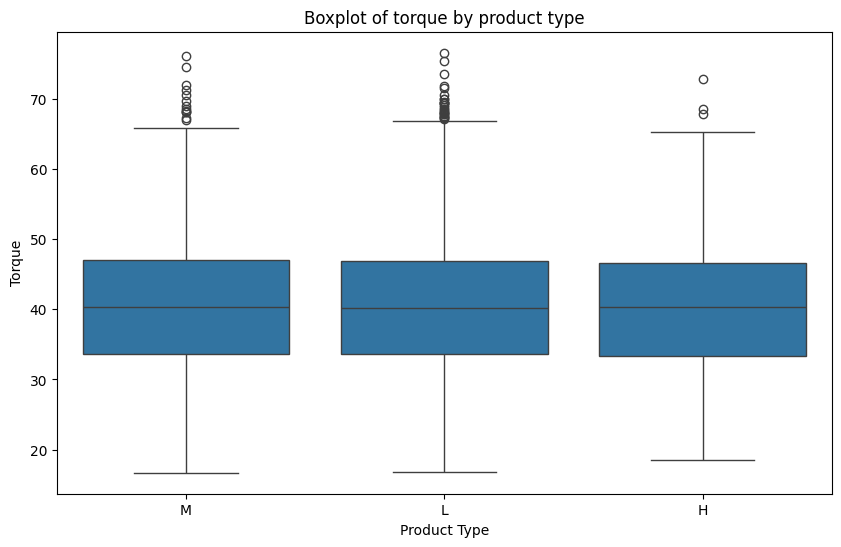

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = 'Product Type', y = 'Torque [Nm]', data=df_unencoded)
plt.title('Boxplot of torque by product type')
plt.xlabel('Product Type')
plt.ylabel('Torque')
plt.show();

Text(0.5, 0, 'Torque [Nm]')

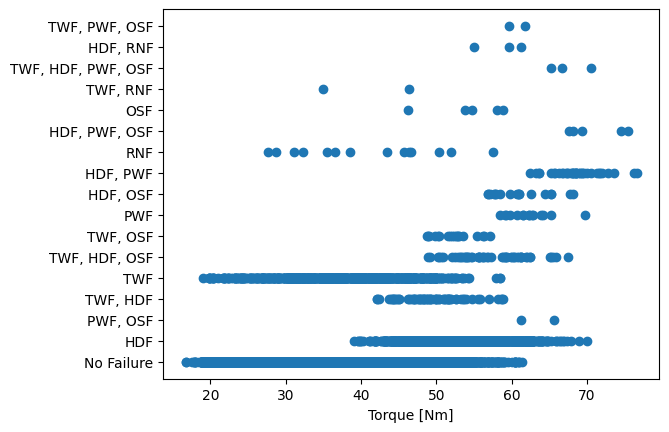

In [7]:
plt.scatter(df_unencoded['Torque [Nm]'], df_unencoded['Machine failure Labelled']);
plt.xlabel('Torque [Nm]')


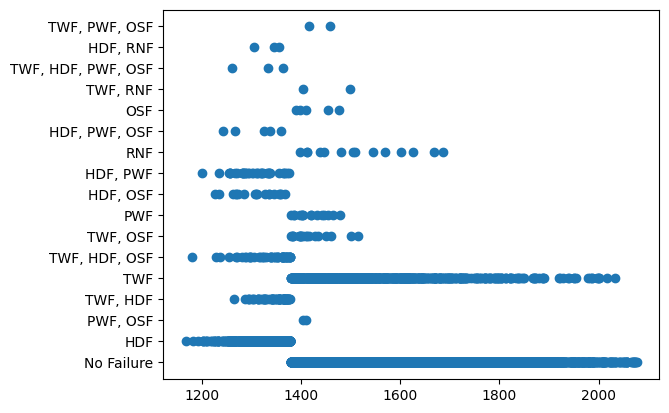

In [8]:
plt.scatter(df_unencoded['Rotational speed [rpm]'], df_unencoded['Machine failure Labelled'])

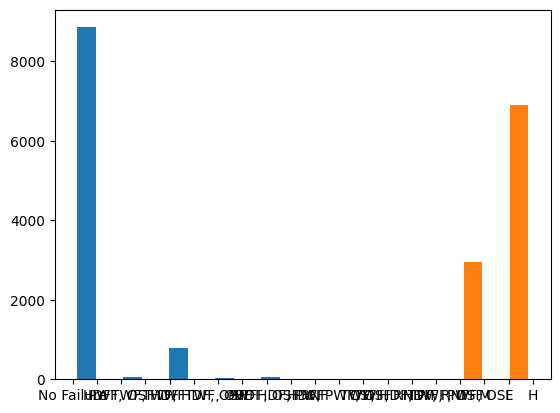

In [9]:
plt.hist([df_unencoded['Machine failure Labelled'], df_unencoded['Product Type']]);

In [10]:
df = pd.read_csv('data/preprocessed_encoded.csv', index_col=0)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
df.head()

,UDI,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Product Type_H,Product Type_L,Product Type_M,...,Machine failure Labelled_PWF,"Machine failure Labelled_PWF, OSF",Machine failure Labelled_RNF,Machine failure Labelled_TWF,"Machine failure Labelled_TWF, HDF","Machine failure Labelled_TWF, HDF, OSF","Machine failure Labelled_TWF, HDF, PWF, OSF","Machine failure Labelled_TWF, OSF","Machine failure Labelled_TWF, PWF, OSF","Machine failure Labelled_TWF, RNF"
0,1,1551,42.8,3,298.095316,299.052687,6951.584688,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1408,46.3,5,298.195303,299.120085,6826.716958,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1498,49.4,7,298.095316,298.985290,7749.380997,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1433,39.5,9,298.195303,299.052687,5927.499652,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1408,40.0,11,298.195303,299.120085,5897.811627,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


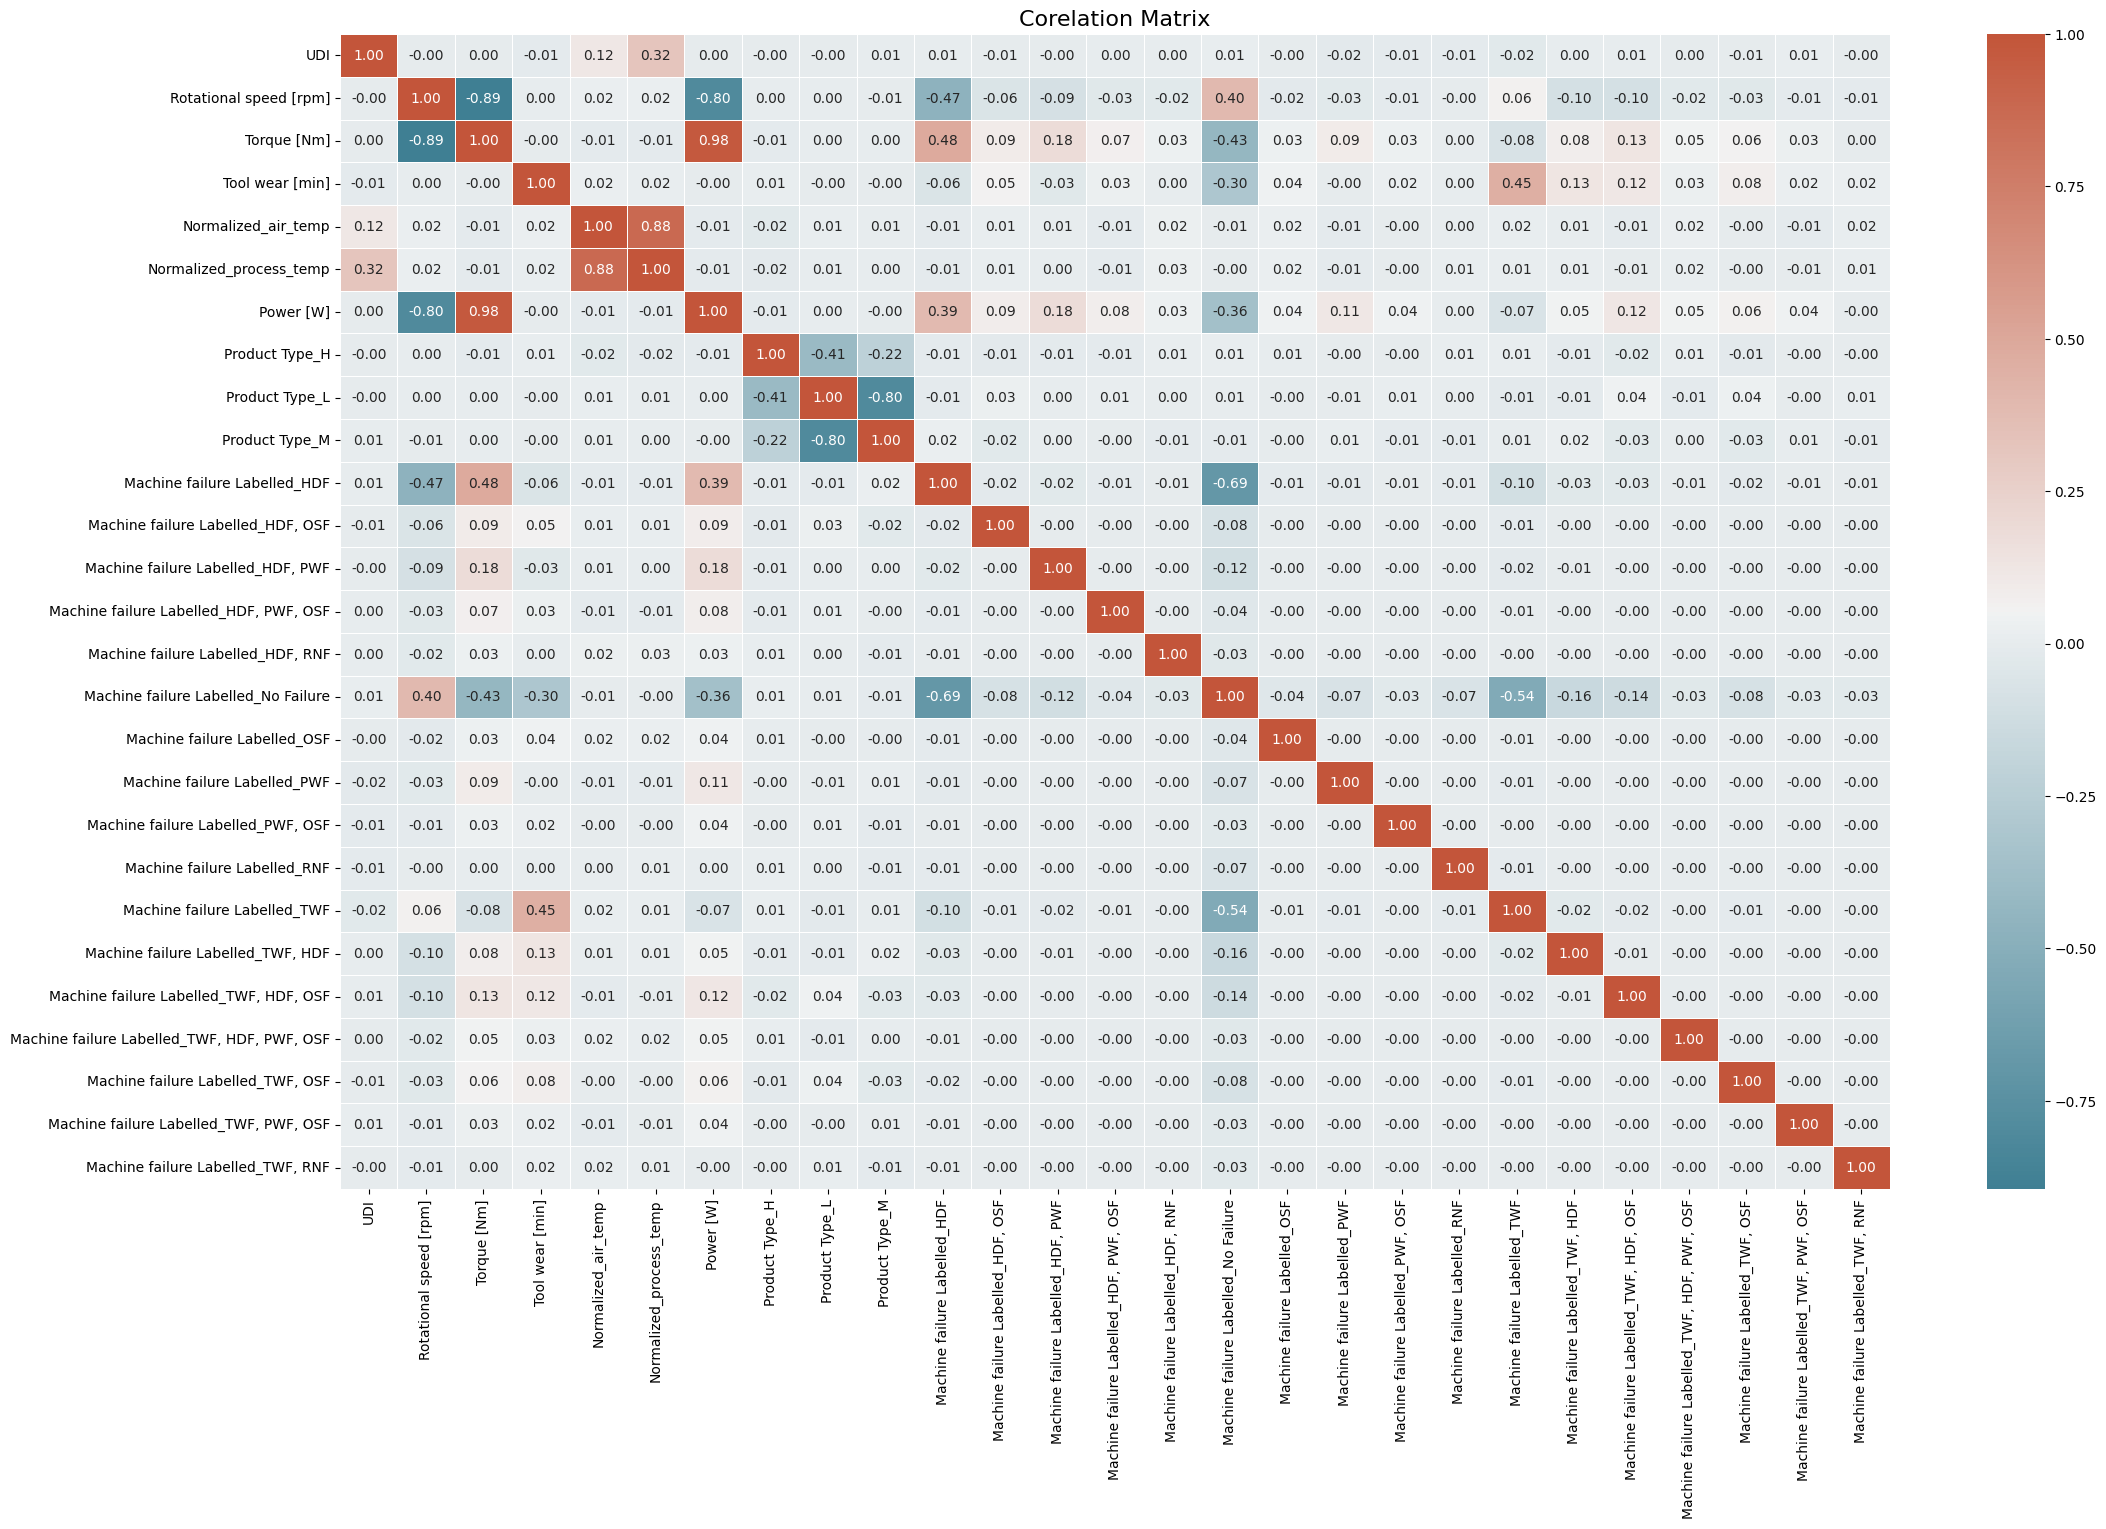

In [12]:
correlation_matrix = df.corr()

plt.figure(figsize=(25, 15))
cmap= sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=.5)
plt.title('Corelation Matrix', fontsize = 16)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

In [14]:
df.columns

Index(['UDI', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Normalized_air_temp', 'Normalized_process_temp', 'Power [W]',
       'Product Type_H', 'Product Type_L', 'Product Type_M',
       'Machine failure Labelled_HDF', 'Machine failure Labelled_HDF, OSF',
       'Machine failure Labelled_HDF, PWF',
       'Machine failure Labelled_HDF, PWF, OSF',
       'Machine failure Labelled_HDF, RNF',
       'Machine failure Labelled_No Failure', 'Machine failure Labelled_OSF',
       'Machine failure Labelled_PWF', 'Machine failure Labelled_PWF, OSF',
       'Machine failure Labelled_RNF', 'Machine failure Labelled_TWF',
       'Machine failure Labelled_TWF, HDF',
       'Machine failure Labelled_TWF, HDF, OSF',
       'Machine failure Labelled_TWF, HDF, PWF, OSF',
       'Machine failure Labelled_TWF, OSF',
       'Machine failure Labelled_TWF, PWF, OSF',
       'Machine failure Labelled_TWF, RNF'],
      dtype='object')

In [23]:
df['Machine Failure'] = df[['Machine failure Labelled_HDF', 'Machine failure Labelled_HDF, OSF',
       'Machine failure Labelled_HDF, PWF',
       'Machine failure Labelled_HDF, PWF, OSF',
       'Machine failure Labelled_HDF, RNF', 'Machine failure Labelled_OSF',
       'Machine failure Labelled_PWF', 'Machine failure Labelled_PWF, OSF',
       'Machine failure Labelled_RNF', 'Machine failure Labelled_TWF',
       'Machine failure Labelled_TWF, HDF',
       'Machine failure Labelled_TWF, HDF, OSF',
       'Machine failure Labelled_TWF, HDF, PWF, OSF',
       'Machine failure Labelled_TWF, OSF',
       'Machine failure Labelled_TWF, PWF, OSF',
       'Machine failure Labelled_TWF, RNF']].any(axis= 1).astype(int)

In [24]:
df.head()

,UDI,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Product Type_H,Product Type_L,Product Type_M,...,"Machine failure Labelled_PWF, OSF",Machine failure Labelled_RNF,Machine failure Labelled_TWF,"Machine failure Labelled_TWF, HDF","Machine failure Labelled_TWF, HDF, OSF","Machine failure Labelled_TWF, HDF, PWF, OSF","Machine failure Labelled_TWF, OSF","Machine failure Labelled_TWF, PWF, OSF","Machine failure Labelled_TWF, RNF",Machine Failure
0,1,1551,42.8,3,298.095316,299.052687,6951.584688,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,1408,46.3,5,298.195303,299.120085,6826.716958,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3,1498,49.4,7,298.095316,298.985290,7749.380997,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4,1433,39.5,9,298.195303,299.052687,5927.499652,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5,1408,40.0,11,298.195303,299.120085,5897.811627,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [25]:
df['Machine Failure'].value_counts()

Machine Failure
0    7679
1    2157
Name: count, dtype: int64

In [26]:
basic_df = df.drop(['Machine failure Labelled_HDF', 'Machine failure Labelled_HDF, OSF',
       'Machine failure Labelled_HDF, PWF',
       'Machine failure Labelled_HDF, PWF, OSF',
       'Machine failure Labelled_HDF, RNF',
       'Machine failure Labelled_No Failure', 'Machine failure Labelled_OSF',
       'Machine failure Labelled_PWF', 'Machine failure Labelled_PWF, OSF',
       'Machine failure Labelled_RNF', 'Machine failure Labelled_TWF',
       'Machine failure Labelled_TWF, HDF',
       'Machine failure Labelled_TWF, HDF, OSF',
       'Machine failure Labelled_TWF, HDF, PWF, OSF',
       'Machine failure Labelled_TWF, OSF',
       'Machine failure Labelled_TWF, PWF, OSF',
       'Machine failure Labelled_TWF, RNF'], axis=1)

In [27]:
basic_df.head()

,UDI,Rotational speed [rpm],Torque [Nm],Tool wear [min],Normalized_air_temp,Normalized_process_temp,Power [W],Product Type_H,Product Type_L,Product Type_M,Machine Failure
0,1,1551,42.8,3,298.095316,299.052687,6951.584688,0.0,0.0,1.0,0
1,2,1408,46.3,5,298.195303,299.120085,6826.716958,0.0,1.0,0.0,0
2,3,1498,49.4,7,298.095316,298.985290,7749.380997,0.0,1.0,0.0,0
3,4,1433,39.5,9,298.195303,299.052687,5927.499652,0.0,1.0,0.0,0
4,5,1408,40.0,11,298.195303,299.120085,5897.811627,0.0,1.0,0.0,0


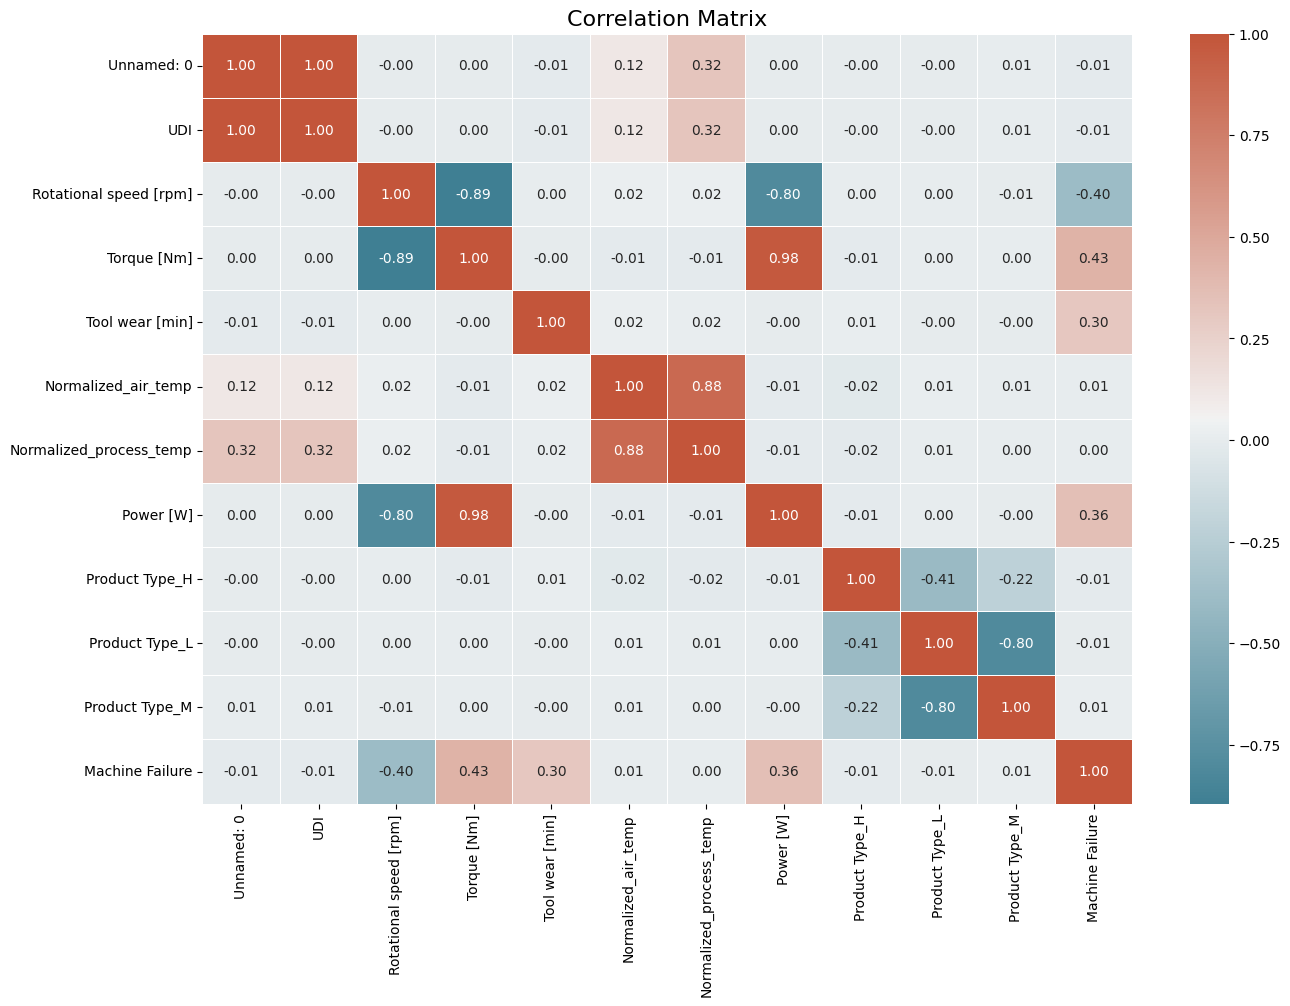

In [35]:
correlation_matrix = basic_df.corr()

plt.figure(figsize=(15, 10))
cmap= sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

In [30]:
basic_df.to_csv('data/basic_df.csv')

### Splitting the data into train, test and  validation set

In [5]:
basic_df = pd.read_csv('data/basic_df.csv')
X = basic_df.drop('Machine Failure', axis=1)
y = basic_df['Machine Failure']

In [6]:
# Splitting the data into training and a temporary set ( test + validation ) 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Splitting the temporary set into validation and test set 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### **Model Training and evaluation**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score

# Initializing the model
cls = LogisticRegression(max_iter=10000)

In [9]:
# Fitting the model 
cls.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [10]:
y_preds = cls.predict(X_val)
accuracy_score(y_val, y_preds)

0.8725423728813559

In [11]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1128
           1       0.78      0.63      0.70       347

    accuracy                           0.87      1475
   macro avg       0.84      0.79      0.81      1475
weighted avg       0.87      0.87      0.87      1475



In [155]:
param_grid = {
    'penalty' : ['l1', 'l2', None],
    'C' : [0.01, 0.1, 1],
    'solver' : ['liblinear', 'lbfgs'],
    'max_iter' : [1000, 10000],
    'tol' : [1e-4, 1e-3, 1e-2],
    'verbose' : [2, 3, 4]
}

In [156]:
from sklearn.model_selection import GridSearchCV, cross_val_score

grid_search = GridSearchCV(estimator= cls, 
                           param_grid= param_grid,
                           cv= 5)                             

grid_search.fit(X, y)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserW

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1186: UserW

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\riwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

[LibLinear]

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1], 'max_iter': [1000, 10000],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['liblinear', 'lbfgs'],
                         'tol': [0.0001, 0.001, 0.01], 'verbose': [2, 3, 4]})

In [157]:
print(f'Best Hyperparameters : {grid_search.best_params_}')
print(f'Best Cross-validation score : {grid_search.best_score_}')

Best Hyperparameters : {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001, 'verbose': 4}
Best Cross-validation score : 0.8777962912445597


In [158]:
cv_preds = grid_search.predict(X_val)

In [159]:
print(classification_report(y_val, cv_preds))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1128
           1       0.78      0.63      0.70       347

    accuracy                           0.87      1475
   macro avg       0.84      0.79      0.81      1475
weighted avg       0.87      0.87      0.87      1475



In [160]:
clf = LogisticRegression(penalty = 'l1',
    C = 0.1,
    solver = 'liblinear',
    max_iter =  1000,
    tol = 0.001,
    verbose = 4)

In [161]:
# Cross-validated accuracy

cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv= 5,
                         scoring= 'accuracy')


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [162]:
cv_acc = cv_acc.mean()
cv_acc

0.877592935881062

In [163]:
# Cross-validated precision

cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv= 5,
                         scoring= 'precision')

cv_precision = np.mean(cv_precision)
cv_precision

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

0.7758261294429193

In [164]:
# Cross-validated recall

cv_recall = cross_val_score(clf,
                         X,
                         y,
                         cv= 5,
                         scoring= 'recall')

cv_recall = np.mean(cv_recall)
cv_recall

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

0.6239892154335309

In [165]:
# Cross-validated F1-score

cv_f1 = cross_val_score(clf,
                         X,
                         y,
                         cv= 5,
                         scoring= 'f1')

cv_f1 = np.mean(cv_f1)
cv_f1

[LibLinear]

[LibLinear][LibLinear][LibLinear][LibLinear]

0.6898479518514864

In [166]:
# Visualising the cross-validated evaluation metrics

cv_metrics = pd.DataFrame({'Accuracy' : cv_acc,
                           'Precision' : cv_precision,
                           'Recall' : cv_recall,
                           'F1-score' : cv_f1 },
                            index = [0])


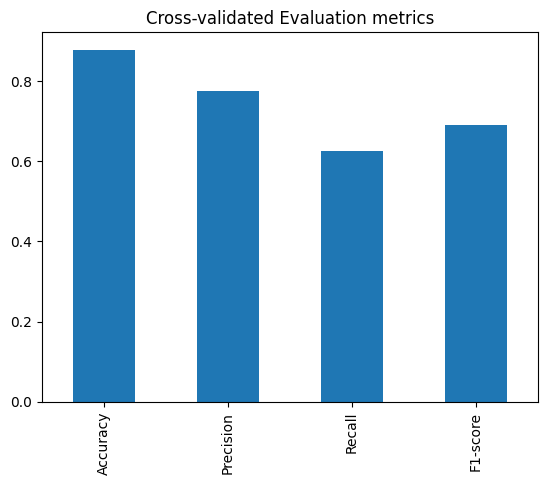

In [167]:
cv_metrics.T.plot.bar(title = 'Cross-validated Evaluation metrics',
                      legend = False);